# 1. Overview

https://www.kaggle.com/c/home-credit-default-risk

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

Inspired by some great kernels:
- sban: https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772
- Will Koehrsen: 
    - https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering 
    - https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- [Aguiar[Updated 0.792 LB] LightGBM with Simple Features](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features/code)
- [Bojan TunguzXGB Simple Features](https://www.kaggle.com/tunguz/xgb-simple-features/code)
- [Ivan TimoshilovFork_LightGBM_with_Simple_Features](https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features)




In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import copy


# 2. Read the Data

In [2]:
path = os.getcwd()
path = os.path.join(path, 'data')
os.listdir(path)

['.DS_Store',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'zip']

Define functions to prepare the data.
- categorical data, get_dummies()
- aggregate with sum, mean, std

In [3]:
# examine fraction of missing value in each attribute
def missing_df(df):
        """
        return a data frame containing the statistics of missing value
        """
        
        total = df.isnull().sum().sort_values(ascending=False)
        fraction = 100 * total / df.shape[0]
        
        # keep to two decimal places
        fraction = fraction.apply(lambda x: round(x,2))
        
        df_missing = pd.concat([total,fraction], axis=1, keys=['Total','Fraction'])
        df_missing.index.name = 'Attributes'
        
        return df_missing
    
    
def cut_missing_fea(df, mis_threshold=60):
    """
    cut off features with ratio of missing values bigger than 60%
    """
    missing = missing_df(df)
    keep_fea = missing[missing['Fraction']<mis_threshold].index

    return df[keep_fea]


    
def prepare_data(df, group_var, prefix):
    
    # cut off featues with too much missing values
    df = cut_missing_fea(df)
    
    # if only one or two categories, factorize()
    for col in df:
        if df[col].dtype == 'object' and len(list(df[col].unique())) <= 2:
            df.loc[:,col], _ = pd.factorize(df[col])
    
    # one hot encoding if more than two categories, including Null
    df = pd.get_dummies(df,dummy_na=True)
    
    # compute sum, mean, std for each column
    d1 = df.drop([group_var],axis=1).groupby('SK_ID_CURR').agg(['sum','mean','std'])
    d1.columns = ['_'.join(col).strip('_ ') for col in d1.columns.values]
    d1.add_prefix(prefix+'_')
    
    # count group_var for each SK_ID_CURR
    d2 = df[['SK_ID_CURR',group_var]].groupby('SK_ID_CURR').count()
    
    # merge 
    df = pd.merge(d1,d2,left_index=True,right_index=True,how='left')
    
    # add prefix
    df = df.add_prefix(prefix+'_')
    
    return df.reset_index()
    

## 2.1 application_train/test

In [4]:
app_train_raw = pd.read_csv(path + '/application_train.csv')
app_test_raw = pd.read_csv(path + '/application_test.csv')
print("app_train.shape = {}, app_test.shape = {}".format(app_train_raw.shape,app_test_raw.shape))
app_train_raw.head()## 2.2 bureau & bureau_balance

app_train.shape = (307511, 122), app_test.shape = (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


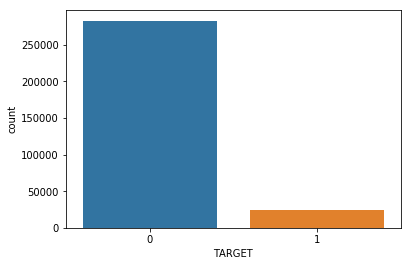

In [8]:
# app_train_raw["TARGET"].plot.hist();
# app_train_raw["TARGET"].hist();

sns.countplot(app_train_raw['TARGET'])
plt.show()

check correlations

In [5]:
corr_Y = app_train_raw.corr(method='pearson')["TARGET"].sort_values()
print(corr_Y.head(10),corr_Y.tail(10),sep='\n\n')

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


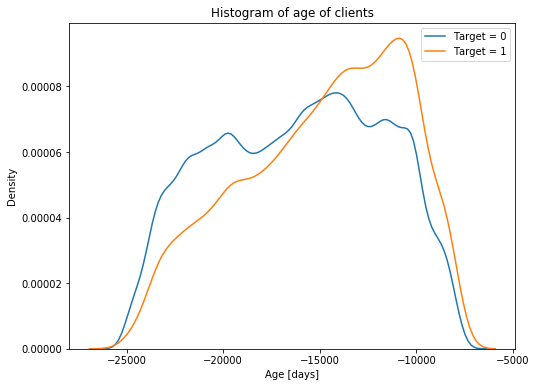

In [11]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.kdeplot(app_train_raw[app_train_raw['TARGET']==0]['DAYS_BIRTH'], label = 'Target = 0')
sns.kdeplot(app_train_raw[app_train_raw['TARGET']==1]['DAYS_BIRTH'], label = 'Target = 1')
plt.title('Histogram of age of clients')
plt.xlabel('Age [days]')
plt.ylabel('Density')
plt.show()

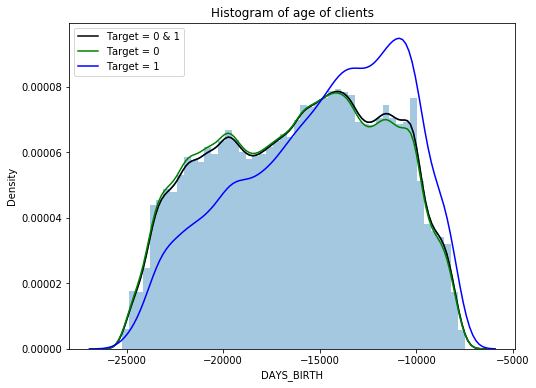

In [33]:
plt.figure(figsize=(8,6))
plt.title('Histogram of age of clients')
plt.xlabel('Age [days]')
plt.ylabel('Density')
sns.distplot(app_train_raw["DAYS_BIRTH"])

sns.kdeplot(app_train_raw['DAYS_BIRTH'], label = 'Target = 0 & 1',color="black")
sns.kdeplot(app_train_raw[app_train_raw['TARGET']==0]['DAYS_BIRTH'], label = 'Target = 0',color="green")
sns.kdeplot(app_train_raw[app_train_raw['TARGET']==1]['DAYS_BIRTH'], label = 'Target = 1',color="b")

plt.show()

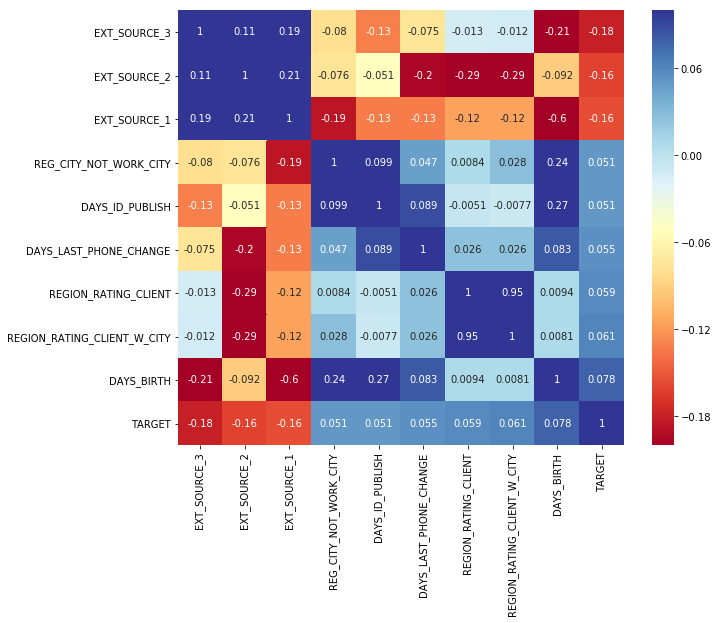

In [12]:
# select only attributes with |corr| > 0.05
indices = corr_Y[abs(corr_Y) > 0.05].index
fea_corr = app_train_raw[indices].corr()

plt.figure(figsize=(10,8))
sns.heatmap(fea_corr, cmap="RdYlBu", annot=True, vmin=-0.2, vmax=0.1)
plt.show()

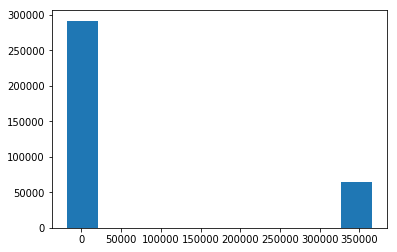

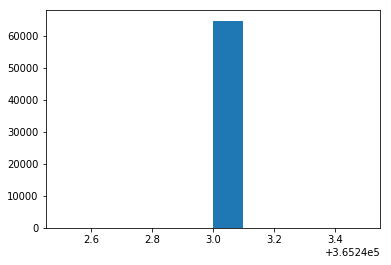

In [34]:
plt.hist(data['DAYS_EMPLOYED'])
plt.show()
plt.hist(data['DAYS_EMPLOYED'][data['DAYS_EMPLOYED']>356*100])
plt.show()

In [16]:
corr2 = app_train_raw[['DAYS_EMPLOYED','TARGET']].corr()
corr2

,DAYS_EMPLOYED,TARGET
DAYS_EMPLOYED,1.000000,-0.044932
TARGET,-0.044932,1.000000


To detect outliers: 
```
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df[mask] = np.nan
```

In [36]:
app_train_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
corr_raw = app_train_raw.corr(method='pearson')["TARGET"].sort_values()
corr_new = df.corr(method='pearson')["TARGET"].sort_values()

In [45]:
print(corr_raw.head(10),corr_Y.tail(10),sep='\n\n')

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


In [46]:
print(corr_new.head(10),corr_Y.tail(10),sep='\n\n')

NEW_EXT_SOURCES_MEAN     -0.222052
NEW_SOURCES_PROD         -0.188552
EXT_SOURCE_3             -0.178919
EXT_SOURCE_2             -0.160472
EXT_SOURCE_1             -0.155317
NEW_CAR_TO_BIRTH_RATIO   -0.048824
DAYS_EMPLOYED            -0.044932
FLOORSMAX_AVG            -0.044003
FLOORSMAX_MEDI           -0.043768
FLOORSMAX_MODE           -0.043226
Name: TARGET, dtype: float64

FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


In [5]:
# we will first concatenate train and test data to simplify the data wrangling

# make a label as to whether the instance belongs to train to test dataset
app_train_raw['is_train'] = 1
app_test_raw['is_train'] = 0

# target for train data
trainY = app_train_raw['TARGET']
app_train_raw.drop('TARGET',axis=1,inplace=True)


# test id 
testID = app_test_raw['SK_ID_CURR']

data = pd.concat([app_train_raw,app_test_raw],axis=0)

assert data.shape[0] == app_train_raw.shape[0] + app_test_raw.shape[0], data.shape[1] == app_train_raw.shape[1]
print("data.shape = ",data.shape)
data.head()

data.shape =  (356255, 122)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [6]:
missing_df(data).head()

,Total,Fraction
Attributes,,
COMMONAREA_MEDI,248360,69.71
COMMONAREA_AVG,248360,69.71
COMMONAREA_MODE,248360,69.71
NONLIVINGAPARTMENTS_MEDI,246861,69.29
NONLIVINGAPARTMENTS_MODE,246861,69.29


In [7]:
trainY.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [6]:
# credit to Bojan TunguzXGB Simple Features
# https://www.kaggle.com/tunguz/xgb-simple-features/code
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [7]:
data['NEW_CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['NEW_CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
data['NEW_ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['NEW_CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].median(),inplace=True)
data['NEW_INC_PER_MEMB'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['NEW_INC_PER_CHLD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])

data['NEW_EMPLOY_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['NEW_CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['NEW_CAR_TO_EMPLOY_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['NEW_PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

data['NEW_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['NEW_EXT_SOURCES_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
data['NEW_SCORES_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
data['NEW_SCORES_STD'].fillna(data['NEW_SCORES_STD'].mean(),inplace=True)

In [8]:
# cut features with too much values
data = cut_missing_fea(data)


# if only one or two categories, factorize()
for col in data:
    if data[col].dtype == 'object' and len(list(data[col].unique())) <= 2:
        data[col], _ = pd.factorize(data[col])

# one hot encoding if more than two categories, including Null
data = pd.get_dummies(data,dummy_na=True)


In [9]:
data.head()

,LANDAREA_MODE,LANDAREA_AVG,LANDAREA_MEDI,BASEMENTAREA_AVG,BASEMENTAREA_MODE,BASEMENTAREA_MEDI,NONLIVINGAREA_AVG,NONLIVINGAREA_MODE,NONLIVINGAREA_MEDI,EXT_SOURCE_1,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan
0,0.0377,0.0369,0.0375,0.0369,0.0383,0.0369,0.0000,0.0,0.00,0.083037,...,0,0,0,0,0,0,0,0,0,0
1,0.0128,0.0130,0.0132,0.0529,0.0538,0.0529,0.0098,0.0,0.01,0.311267,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data.shape

(356255, 245)

## 2.2 bureau & bureau_balance

In [11]:
bureau = pd.read_csv(path + '/bureau.csv')
bureau_balance = pd.read_csv(path + '/bureau_balance.csv')
print("bureau.shape = {}, bureau_balance.shape = {}".format(bureau.shape,bureau_balance.shape))

bureau.shape = (1716428, 17), bureau_balance.shape = (27299925, 3)


In [58]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [28]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,0
1,5715448,-1,0
2,5715448,-2,0
3,5715448,-3,0
4,5715448,-4,0


**bureau_balance** is the status of Credit Bureau loan during the month. Month of balance relative to application date (-1 means the freshest balance date). For **STATUS** column, 
- **C**: closed 
- **X**: status unknown, 
- **0 - 5**: DPD (Days Past Due, _the number of days a payment on a respective account has been delayed_). 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 3 means 61-90, 4 means 91-120, 5 means DPD 120+ or sold or written off)

In [19]:
missing_df(bureau).head()

,Total,Fraction
Attributes,,
AMT_ANNUITY,1226791,71.47
AMT_CREDIT_MAX_OVERDUE,1124488,65.51
DAYS_ENDDATE_FACT,633653,36.92
AMT_CREDIT_SUM_LIMIT,591780,34.48
AMT_CREDIT_SUM_DEBT,257669,15.01


There is no missing value in bureau_balance. I will only take the sum of DPD from bureau_balance. This variable might be related to the economic condition. 

In [12]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace(['C','X'],'0').apply(lambda x:int(x))
bb = bureau_balance['STATUS'].groupby(bureau_balance['SK_ID_BUREAU']).sum().to_frame()

# merge the sum of DPD
bureau = pd.merge(bureau,bb,left_on='SK_ID_BUREAU',right_index=True,how='left')
print("bureau.shape = ",bureau.shape)

bureau.shape =  (1716428, 18)


Now we will deal with **categorical feature** and **numerical feature**. First do one-hot encoding for categorical features. Then aggregate by sum, mean, std.

In [13]:
bureau = prepare_data(bureau,group_var='SK_ID_BUREAU',prefix='bureau')
print("bureau.shape = ",bureau.shape)


# merge with  data
data = pd.merge(data,bureau,how='left')
data.shape

bureau.shape =  (305811, 113)


(356255, 357)

In [15]:
del bureau, bureau_balance

## previous application

In [47]:
os.listdir(path)

['.DS_Store',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'zip']

Applications data of client's previous loans in Home Credit. Info about the previous loan parameters and client info at time of previous application. One row per previous application

In [14]:
prev_app = pd.read_csv(path + '/previous_application.csv')
print("prev_app.shape = ",prev_app.shape)
prev_app.head()

prev_app.shape =  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
prev_app['DAYS_FIRST_DRAWING'].describe()

count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [15]:
col_DAYS = []
for col in prev_app:
    if 'DAYS' in col:
        col_DAYS.append(col)

for col in col_DAYS:
    prev_app[col].replace(365243,np.nan,inplace=True)
del col_DAYS

In [18]:
prev_app.shape

(1670214, 37)

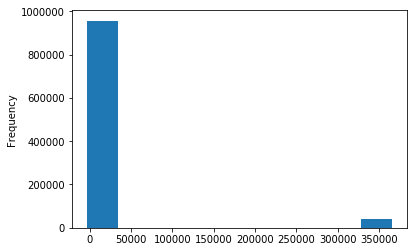

In [66]:
prev_app['DAYS_FIRST_DRAWING'].plot.hist()
plt.show()

In [16]:
prev_app = prepare_data(prev_app,group_var='SK_ID_PREV',prefix='prev_app')


print("data.shape = {}, prev_app = {}".format(data.shape,prev_app.shape))


/Users/ruizheng/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


data.shape = (356255, 357), prev_app = (338857, 521)


In [17]:
# merge with  data
data1 = pd.merge(data,prev_app,how='left')
data1.shape

(356255, 877)

In [18]:
data = data1

Monthly balance of client's previous loans in Home Credit. Behavioral data.

In [19]:
pos_bal = pd.read_csv(path + '/POS_CASH_balance.csv')
print("pos_bal.shape = ",pos_bal.shape)
pos_bal.head()


pos_bal.shape =  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [20]:
pos_bal = prepare_data(pos_bal,group_var='SK_ID_PREV',prefix='pos')

print("data.shape = {}, pos_bal.shape = {}".format(data.shape,pos_bal.shape))
# merge with  data
data = pd.merge(data,pos_bal,how='left')
data.shape

data.shape = (356255, 877), pos_bal.shape = (337252, 47)


(356255, 923)

In [21]:
del pos_bal, prev_app

Past payment data for each installments of previous credits in Home Credit related to loans in our sample. Behavioral data.

In [22]:
install_pay = pd.read_csv(path + '/installments_payments.csv')
print("install_pay.shape = ",install_pay.shape)
install_pay.head()

install_pay.shape =  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [23]:
install_pay = prepare_data(install_pay,group_var='SK_ID_PREV',prefix='install')

print("data.shape = {}, install_pay.shape = {}".format(data.shape,install_pay.shape))
# merge with  data
data = pd.merge(data,install_pay,how='left')
data.shape

data.shape = (356255, 923), install_pay.shape = (339587, 20)


(356255, 942)

Monthly balance of client's previous credit card loans in Home Credit. Bhavioral data.

In [24]:
credit_bal = pd.read_csv(path + '/credit_card_balance.csv')
print("credit_bal.shape = ",credit_bal.shape)
credit_bal.head()

credit_bal.shape =  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [25]:
credit_bal = prepare_data(credit_bal,group_var='SK_ID_PREV',prefix='credit')

print("data.shape = {}, credit_bal.shape = {}".format(data.shape,credit_bal.shape))
# merge with  data
data = pd.merge(data,credit_bal,how='left')
data.shape

data.shape = (356255, 942), credit_bal.shape = (103558, 86)


(356255, 1027)

In [26]:
del credit_bal, install_pay

In [68]:
data.to_csv("data.csv")

# Model

In [27]:
missing = missing_df(data)
keep_attr = missing[missing['Fraction']<60].index

data1 = data[keep_attr]
print("data1.shape = ",data1.shape)
del missing, keep_attr

data1.shape =  (356255, 940)


In [28]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score,accuracy_score

In [29]:
#### prepare final Train X and Test X dataframes 
ignore_features = ['SK_ID_CURR', 'is_train']
relevant_features = [col for col in data1.columns if col not in ignore_features]
trainX = data1[data1['is_train'] == 1][relevant_features]
testX = data1[data1['is_train'] == 0][relevant_features]

In [37]:
data1.shape

(356271, 830)

In [64]:
print(trainX.shape,testX.shape)

(307511, 868) (48744, 868)


In [30]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
imputer.fit(trainX)
trainX = imputer.transform(trainX)
testX = imputer.transform(testX)

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(trainX)
trainX, testX = scaler.transform(trainX), scaler.transform(testX)

In [36]:
trainY.shape

(307511,)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [374]:
data1.head()

,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MODE,BASEMENTAREA_MEDI,NONLIVINGAREA_AVG,NONLIVINGAREA_MODE,NONLIVINGAREA_MEDI,EXT_SOURCE_1,...,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Academic degree,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_block of flats,FONDKAPREMONT_MODE_reg oper spec account,ORGANIZATION_TYPE_Bank
0,0.0369,0.0375,0.0377,0.0369,0.0383,0.0369,0.0000,0.0,0.00,0.083037,...,0,0,0,0,1,0,0,1,0,0
1,0.0130,0.0132,0.0128,0.0529,0.0538,0.0529,0.0098,0.0,0.01,0.311267,...,0,1,0,0,1,0,0,1,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


In [375]:
trainX[0][:10]

array([-0.35433328, -0.35188498, -0.29996841, -0.83164731, -0.76214756,
       -0.82494028, -0.30525518, -0.26079617, -0.29553915, -3.02187729])

## Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10)
dt.fit(x_train,y_train)
# cross_val_score(dt,trainX,trainY,cv=10)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [70]:
Y_score = dt.predict_proba(x_val)
roc_auc_score(y_val,Y_score[:,1])

0.7073009838093005

In [71]:
accuracy_score(dt.predict(x_train),y_train)

0.919205879483594

In [72]:
accuracy_score(dt.predict(x_val),y_val)

0.9195323805342829

## 5.2 Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(x_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
Y_score = log_reg.predict_proba(x_val)
roc_auc_score(y_val,Y_score[:,1])

0.7496071450526817

In [35]:
## 5.3 Random Forest

from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(x_train,y_train)


# Make predictions on the test data
Y_score = random_forest.predict_proba(x_val)
roc_auc_score(y_val,Y_score[:,1])

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


0.7155274495472164

In [36]:
pred = random_forest.predict(x_val)
accuracy_score(pred,y_val)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


0.9196787148594378

In [33]:
import lightgbm as lgb
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [34]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=100, verbose_eval=20)

/Users/ruizheng/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.739081
[40]	valid_0's auc: 0.741593
[60]	valid_0's auc: 0.744889
[80]	valid_0's auc: 0.747183
[100]	valid_0's auc: 0.749556
[120]	valid_0's auc: 0.751877
[140]	valid_0's auc: 0.75433
[160]	valid_0's auc: 0.756216
[180]	valid_0's auc: 0.758111
[200]	valid_0's auc: 0.759829
[220]	valid_0's auc: 0.761335
[240]	valid_0's auc: 0.762649
[260]	valid_0's auc: 0.763954
[280]	valid_0's auc: 0.765377
[300]	valid_0's auc: 0.766673
[320]	valid_0's auc: 0.767792
[340]	valid_0's auc: 0.768751
[360]	valid_0's auc: 0.769592
[380]	valid_0's auc: 0.770427
[400]	valid_0's auc: 0.771224
[420]	valid_0's auc: 0.771969
[440]	valid_0's auc: 0.77267
[460]	valid_0's auc: 0.773281
[480]	valid_0's auc: 0.77375
[500]	valid_0's auc: 0.774171
[520]	valid_0's auc: 0.774646
[540]	valid_0's auc: 0.775071
[560]	valid_0's auc: 0.775468
[580]	valid_0's auc: 0.775894
[600]	valid_0's auc: 0.776209
[620]	valid_0's auc: 0.776586
[640]	valid_0'

# 6 Submission

In [35]:
test_Y_score = model.predict(testX)
submit = pd.DataFrame({'SK_ID_CURR':testID.values, 'TARGET':test_Y_score})
submit.set_index('SK_ID_CURR')

,TARGET
SK_ID_CURR,
100001,0.036724
100005,0.131599
100013,0.020194
100028,0.036068
100038,0.176504
100042,0.044243
100057,0.010878
100065,0.043535
100066,0.017499


In [36]:
# Save the submission dataframe
submit.to_csv('lightgbm_20180718_sub5.csv', index = False)

In [43]:
testID.values

array([100001, 100005, 100013, ..., 456223, 456224, 456250])